<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
#install GluonTS
#!pip install --upgrade mxnet~=1.7 gluonts

In [3]:
#metatrader 5 history file an timeframe is ok
df = pd.read_csv('/content/EURUSD_H1_197101040000_202201212300.csv')


In [4]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [5]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,1971.01.04,00:00:00,0.53690,0.53690,0.53690,0.53690,1,0,50
1,1971.01.05,00:00:00,0.53660,0.53660,0.53660,0.53660,1,0,50
2,1971.01.06,00:00:00,0.53650,0.53650,0.53650,0.53650,1,0,50
3,1971.01.07,00:00:00,0.53680,0.53680,0.53680,0.53680,1,0,50
4,1971.01.08,00:00:00,0.53710,0.53710,0.53710,0.53710,1,0,50
...,...,...,...,...,...,...,...,...,...
150257,2022.01.21,19:00:00,1.13456,1.13498,1.13397,1.13457,2378,0,0
150258,2022.01.21,20:00:00,1.13457,1.13490,1.13417,1.13444,1714,0,0
150259,2022.01.21,21:00:00,1.13443,1.13465,1.13407,1.13413,1480,0,0
150260,2022.01.21,22:00:00,1.13411,1.13452,1.13380,1.13412,2289,0,0


In [6]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                 0         1        5
0       1971.01.04  00:00:00  0.53690
1       1971.01.05  00:00:00  0.53660
2       1971.01.06  00:00:00  0.53650
3       1971.01.07  00:00:00  0.53680
4       1971.01.08  00:00:00  0.53710
...            ...       ...      ...
150257  2022.01.21  19:00:00  1.13457
150258  2022.01.21  20:00:00  1.13444
150259  2022.01.21  21:00:00  1.13413
150260  2022.01.21  22:00:00  1.13412
150261  2022.01.21  23:00:00  1.13421

[150262 rows x 3 columns]


In [7]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [8]:
new_df = new_df.rename(columns={5:'price'})

In [9]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
1971-01-04 00:00:00  0.53690
1971-01-05 00:00:00  0.53660
1971-01-06 00:00:00  0.53650
1971-01-07 00:00:00  0.53680
1971-01-08 00:00:00  0.53710
...                      ...
2022-01-21 19:00:00  1.13457
2022-01-21 20:00:00  1.13444
2022-01-21 21:00:00  1.13413
2022-01-21 22:00:00  1.13412
2022-01-21 23:00:00  1.13421

[150262 rows x 1 columns]


In [10]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150262 entries, 1971-01-04 00:00:00 to 2022-01-21 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   price   150262 non-null  float64
dtypes: float64(1)
memory usage: 2.3 MB


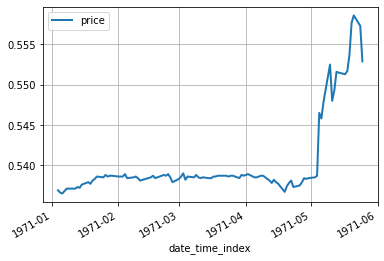

In [11]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [12]:
#import Gluon
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [31]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2000-01-01 01:00:00":"2022-01-12 01:00:00"]}], 
    freq = "1H"
    )

In [14]:
#import model 
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
#train model
estimator = DeepAREstimator(freq="1H", prediction_length=24, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-01-18 01:00:00"]}],
    freq = "1H"
)

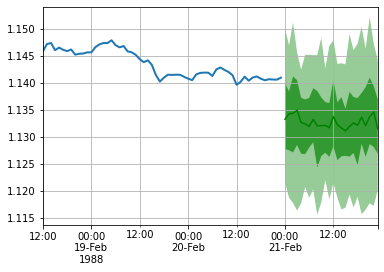

In [30]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')